# ANN Local Fit

Overview:

In the so-called "Local Fit", the goal is to extract three Compton Form Factors (CFF)s for each data set.
Zeroth step is to get an idea of the data set, so you need to take a look at the .cvs file.

**Important: The last three columns "ReH, ReE, ReHtilde" are the CFFs that you need to extract so you need to assume that you are not given those three columns. Those columns are provided just only for cross-checking and the values in those columns are reffered as "true" values".**

1. "#Set" column continues with the same value until the "index" column run from 0-35: reflects to "phi_x" (is an angle)          running from 0 to 360 degrees with intervals of 8 degrees. Also, note that the columns "F" and "errF" are also changing
   with "index" and "phi_x".
2. Note that rest of all numbers in that section (refers to #Set = 0 for example) remain unchanged.
3. Before starting any extractions, the first step is to make a plot of "F" vs "phi_x" for a selected "#Set": like you measured 
   "F" with respect to the angle "phi_x" in an experiment. You can include error bars for "F" using "errF" in your plot(s).
   
   
Now, "F" is a function which can be parameterize explicitely in terms of it's dependencies:
**k, QQ, x_b, t, phi_x, F_1, F_2, dvcs, ReH, ReE, ReHtilde**

Among those dependencies of "F":
1. k, QQ, x_b, t are called as  **Kinematics**
2. F_1, F_2, dvcs are identifies ad **Other constants**
3. ReH, ReE, ReHtilde are the CFFs which we have to extract for each data-set/kinematic setting. You will notice that these        three CFFs are varying over data-sets/kinematics, therefore these CFFs can be identified as functions which are also depend    on the kinematics (k,QQ,x_b,t). **Understanding the behavior of CFFs over kinematics, or in other words, extracting the        kinematical dependence of CFFs is called "Global Fit/extraction of CFFs"**.


### Note the following imports:

#### "BHDVCStf" is the class which contains the definition of the total Cross-Section "F" and the "utilities" file contains all the definitions which handles the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts #general utilities that are useful for all methods

## Importing the function "F" and the data file into data-frames

In [2]:
bhdvcs = BHDVCS()
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

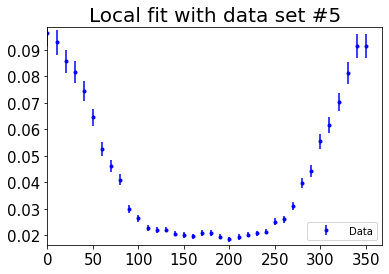

In [3]:
def F2VsPhi(dataframe,SetNum):
    TempFvalSilces=dataframe[dataframe["#Set"]==SetNum]
    TempFvals=TempFvalSilces["F"]
    TempFvals_sigma=TempFvalSilces["errF"]
    temp_phi=TempFvalSilces["phi_x"]
    plt.errorbar(temp_phi,TempFvals,TempFvals_sigma,fmt='.',color='blue',label="Data")
    plt.xlim(0,368)
    temp_unit=(np.max(TempFvals)-np.min(TempFvals))/len(TempFvals)
    plt.ylim(np.min(TempFvals)-temp_unit,np.max(TempFvals)+temp_unit)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc=4,fontsize=10,handlelength=3)
    plt.title("Local fit with data set #"+str(SetNum),fontsize=20)

### Here you can change the #Set in the 2nd argument of the following function ###
### #Set = {0,14} ###
F2VsPhi(df,5)    

In [4]:
# "numSets" is equal to the number of data-sets in the .csv file (#Set) 
# "numReplicas" is the number of replicas that you want to produce from each data-set (for each #Set ID) varying the "F"
#  within "errF".

numSets = 15
numReplicas = 30

## Define and compile model

This makes use of the tensorflow [functional api](https://www.tensorflow.org/guide/keras/functional)

In [5]:
kinematics = tf.keras.Input(shape=(4))
### Here the shape is 4 because only k,QQ,x_b,t are considered as "inputs" ###
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
### Defining the dense layers / architecture of the ANN model ###
outputs = tf.keras.layers.Dense(3)(x) 
### three output nodes for CFFs (ReH, ReE, ReHtilde) ###

#### Once you have the three CFFs from the NN model, then you can feed those in with other non CFF inputs (Kinematics, other inputs) 
#### to generate "F" because "F" depends on all those 8 inputs ####
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = uts.TotalUUXSlayer()(totalUUXSInputs) 
### incorporate total cross-section function ####

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

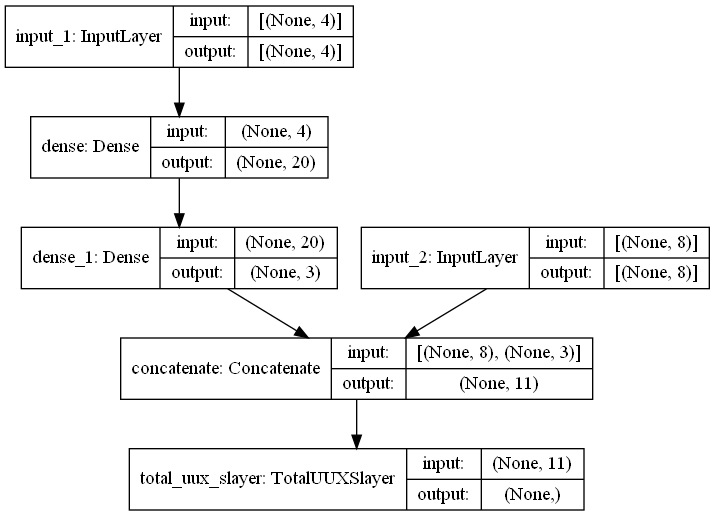

In [6]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [7]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(.02),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [8]:
Wsave = globalModel.get_weights()

## Produce CFFdists

In [9]:
print(Wsave[0])

[[-1.41477942e-01 -3.64363194e-01 -1.37392163e-01  4.64040041e-01
  -4.99125481e-01  1.37385130e-02 -1.76309705e-01  1.71053410e-03
  -9.64708328e-02 -1.00935578e-01 -3.68297935e-01 -1.01694465e-01
  -8.51309299e-03 -9.51206684e-03 -1.64921522e-01  3.19838524e-04
   4.82938290e-01  1.65333152e-01 -4.41086531e-01  3.14256430e-01]
 [ 4.21860695e-01 -3.27305794e-01 -3.63924503e-02 -2.22110868e-01
   1.40826821e-01 -2.60092020e-02  3.23430061e-01  1.30878568e-01
   3.56086731e-01 -4.43832278e-01 -1.40126228e-01  4.41790819e-02
  -1.28591537e-01  4.19149756e-01 -3.93476963e-01  4.02142525e-01
   3.17052960e-01 -4.80853200e-01 -1.44350767e-01 -1.67065740e-01]
 [-4.59891558e-01 -2.03002930e-01 -3.49409342e-01  2.44965911e-01
   1.70600414e-03  5.41484356e-02 -2.82027245e-01 -2.49184370e-02
  -5.69478273e-02  2.88330674e-01 -1.02338791e-02 -2.00268984e-01
  -2.24759817e-01  4.75986362e-01 -4.57258821e-01 -4.88927364e-02
   3.65668178e-01 -3.85541201e-01 -3.39573741e-01  3.87689352e-01]
 [-1.72

In [10]:
def produceCFFs(numReplicas, data, Wsave):
    '''
    :param numSamples: number of replicas to produce
    :param data: whole DvcsData
    :param Wsave: saved weights
    
    :returns: numpy array of shape (numSets, numReplicas, 3)
    '''

    by_sample = []

    for i in tqdm(range(max(data.df['#Set'])+1)):

        globalModel.set_weights(Wsave) # reset weights to original value

        setI = data.getSet(i) #DvcsData object containing specific set

        by_set = []

        for sample in range(numReplicas):

            globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # the sample Y will generate Fs
                        epochs=2500, verbose=0)
 
            cffs = uts.cffs_from_globalModel(globalModel, setI.Kinematics) # get cffs from middle model

            by_set.append(cffs)

        by_sample.append(by_set)
        
    return np.array(by_sample)

This took about 2 hours to run

In [38]:
results = produceCFFs(30, data, Wsave)

# ReH

In [42]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  17.582291982537622
RMSE:  2.62230203097768
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -0.07816059768698325


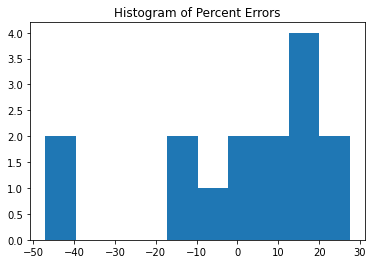

In [43]:
uts.evaluate(y_yhat)

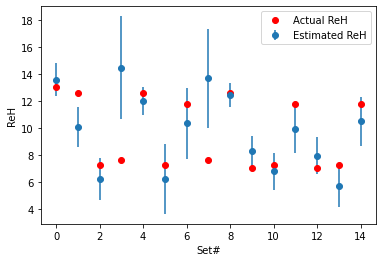

In [44]:
uts.plotError(y_yhat, err, "ReH")

# ReE

In [50]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)

Mean percent error:  17.90242207338664
RMSE:  13.365320875688067
RMSE w yhat=mean:  2.525480507907797
R-squared:  -27.007267395838852


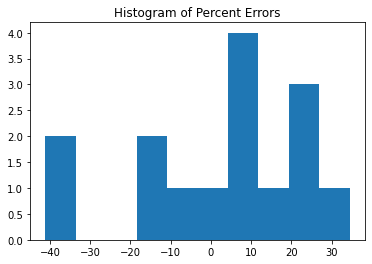

In [51]:
uts.evaluate(y_yhat)

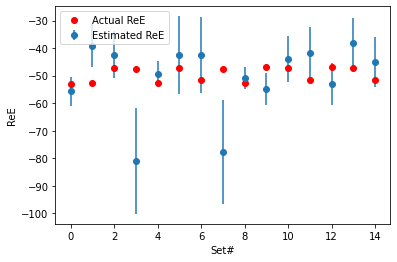

In [53]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  13.752452678886966
RMSE:  1.3588621505320975
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.06197575189024063


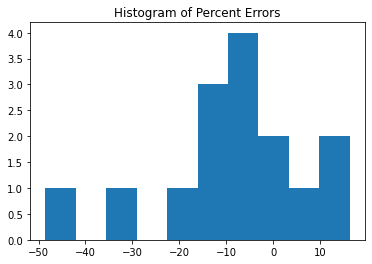

In [45]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

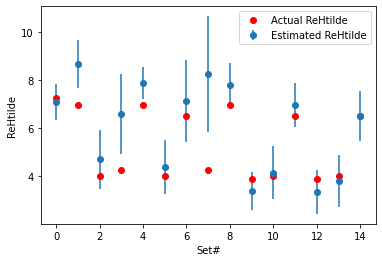

In [46]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Mean percent error:  5.704536590802014
RMSE:  0.002553727446558777
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.9740593416573334


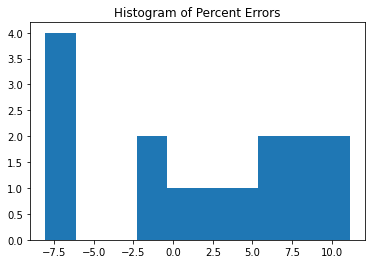

In [47]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

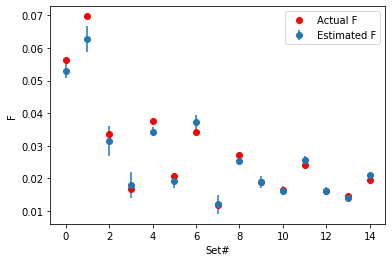

In [48]:
uts.plotError(y_yhat, err, "F")

# Histograms of CFFs 

Here is an example of pre-processed data (called using "replicas500_CFFs.txt" file as a demonstration)

(array([  5.,  29.,  56., 102., 116.,  90.,  69.,  23.,   8.,   2.]),
 array([-0.65943888,  0.9290155 ,  2.51746989,  4.10592428,  5.69437867,
         7.28283305,  8.87128744, 10.45974183, 12.04819622, 13.6366506 ,
        15.22510499]),
 <BarContainer object of 10 artists>)

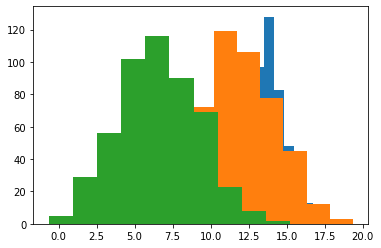

In [11]:
def Histogram_Data(fitname,setnum,cffnum):
    Cffdat=[]
    LL=len(fitname[setnum])
    for i in range(LL):
        Cffdat.append(fitname[setnum][i][cffnum])
    return np.array(Cffdat)

fit_open=np.fromfile("replicas500_CFFs.txt")
reshaped_data=fit_open.reshape(15,500,3)

plt.hist(Histogram_Data(reshaped_data,0,0))
plt.hist(Histogram_Data(reshaped_data,1,0))
plt.hist(Histogram_Data(reshaped_data,2,0))